# develop graphics/movies for `SODTM1S`, `JNH4`, and `JNO3`

In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import pandas 
import numpy as np
import pathlib
import yaml
import sys
import xarray
import numpy
import geopandas as gpd
import contextily as cx 
from datetime import date
import matplotlib.pyplot as plt


sys.path.insert(1, '../scripts/')
from ssm_utils import reshape_fvcom, calc_fvcom_stat

with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)

## Load spreadsheet with station data and SSM nodes

In [10]:
sta_dir = pathlib.Path("/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediment")
sta_file = sta_dir/"Rigby_measured_import20221016.xlsx"
sediment_f = pandas.read_excel(
    sta_file,
    skiprows=3,
    sheet_name="NodeIDExport",
)
[*sediment_f]

['Latitude ',
 'Longitude ',
 'Station',
 'Node ID',
 'MovedOutside of Masked',
 'PSI DatabaseLocationName',
 'Region',
 'DO',
 'DO_SE',
 'DIC',
 'DIC_SE',
 'NH4',
 'NH4_SE',
 'NO3_',
 'NO3_SE',
 'Si',
 'Si_SE',
 'PO43',
 'PO43_SE',
 'Denit_DIN']

In [11]:
# group by "Region"
sediment_f[['Station','Region']].groupby("Region").count()

,Station
Region,
Hood,3
Hood Canal,3
Main,11
Main Basin,1
SJFandAdmiralty,2
SOG_Bellinghham,5
South_Sound,8
Strait of Georgia/Northern Bay,1
Whidbey,8


In [12]:
sediment_f[['Station','Region']].groupby("Region").count().Station["SOG_Bellinghham"] + sediment_f[['Station','Region']].groupby("Region").count().Station["Strait of Georgia/Northern Bay"]

6

In [13]:
for idx in range(len(sediment_f['Node ID'])):
    print(sediment_f['Station'][idx],sediment_f['Node ID'][idx], sediment_f['MovedOutside of Masked'][idx])

4 6261 0
13 8010 1
19 9725 0
21 9396 0
29 9136 0
34 11883 0
38 11967 0
49 15583 0
52 14854 0
191 10633 0
209 7796 0
222 9780 0
252 15325 0
265 14392 0
281 13265 0
305R 14049 0
40005 3225 1
40006 9789 0
40007 8407 0
40008 14268 0
40009 5846 0
40010 11500 0
40011 8827 0
40013 4725 0
40015 9836 0
40016 15234 0
40017 5956 0
40018 13094 0
40019 8394 0
40020 9309 0
40021 8488 0
40022 10005 0
40025 4496 1
40028 15860 0
40029 6048 0
40030 11793 0
40032 15687 0
40037 8762 0
40038 9214 0
BLL009 6160 0
HCB003 10633 0
Dabob_1977_110m 10275 1


## Load processed netcdf

In [14]:
sed_dir=pathlib.Path("/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/")
base = "ssm_output_sediments_WQM.nc"
ref = "ssm_output_sediments_WQM_REF.nc"
xr_base = xarray.open_dataset(sed_dir/base, engine='netcdf4')
[*xr_base]

['h',
 'zeta',
 'NH4',
 'NO3',
 'netPP',
 'JPON1',
 'JPON2',
 'JPON3',
 'SODTM1S',
 'JNH4',
 'JNO3',
 'sed_NH41',
 'sed_NH42',
 'sed_NO31',
 'sed_NO32',
 'sed_CPON1',
 'sed_CPON2',
 'sed_CPON3']

In [15]:
xr_base['JNO3'][:,:].shape

(8784, 16012)

In [16]:
fvcom_reshaped = numpy.reshape(
    xr_base['JNO3'][:,:].data, (366,24,16012)
)

In [17]:
np_operator="mean"
daily_stat = {}
for var in ['SODTM1S', 'JNH4', 'JNO3']:
    daily = reshape_fvcom(
        xr_base[var],'days'
    )
    # calculate daily minimum
    daily_tmp = calc_fvcom_stat(daily, np_operator, axis=1)
    # remove spin-up days
    daily_stat[var] = np.delete(
        daily_tmp,range(0,ssm['run_information']['spin_up_days']),0)
 
# print out min, max, median for graphics
for var in ['SODTM1S', 'JNH4', 'JNO3']:
    print(var,": ",daily_stat[var].min(),daily_stat[var].max(),daily_stat[var].mean())

8784 16012
reshaping to days
8784 16012
reshaping to days
8784 16012
reshaping to days
SODTM1S :  0.0031077878 5.506407 0.5841201
JNH4 :  -0.06364579 0.32951364 0.023687456
JNO3 :  -0.11752355 0.012957938 -0.009076984


# Create timeseries for Rigby stations and save to spreadsheets

In [18]:
processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])
output_directory = processed_netcdf_dir/'sediments'

# make README 
created_by = 'Rachael D. Mueller'
created_at = 'Puget Sound Institute'
created_from = 'Model results produced by Su Kyong Yun at the Salish Sea Modeling Center'
created_on = date.today().strftime("%B %d, %Y")
this_file = sys.path[0]+'dev_plot_sedimentFluxes.ipynb'
contact = 'Rachael D Mueller (rdmseas@uw.edu)'
header = {
    ' ':[created_by, created_at, created_on, this_file,
        contact, created_from]
}
header_df = pandas.DataFrame(header, index=[
    'Created by',
    'Created at',
    'Created on',
    'Created with',
    'Contact',
    'Modeling by'])


# get time series based on geopandas dataframe index value
run='base'
ts={}
ts_df={}
monthly_mean_df={}
for var in ['SODTM1S', 'JNH4', 'JNO3']:
    ts[var]={}
    ts[var]['date']=np.arange(
        np.datetime64('2014-01-05'), np.datetime64('2015-01-01')
    )
    for idx_sta,node_index in enumerate(sediment_f['Node ID']):
        ts[var][f"Station {sediment_f['Station'][idx_sta]}"]=daily_stat[var][:,node_index]
    
    # Convert to dataframe and organize information
    ts_df[var] = pandas.DataFrame(ts[var])
    
    # calculate the monthly mean
    monthly_mean_df[var] = ts_df[var].groupby(pandas.PeriodIndex(pandas.to_datetime(ts[var]['date']), freq="M"))[[*ts_df[var]]].mean()
    
    # Save to output to 
    with pandas.ExcelWriter(
        output_directory/f'base_{var}_Ridgby2019_locations_TS.xlsx', mode='w') as writer:  
        ts_df[var].to_excel(writer, sheet_name='Baseline Timeseries')
        header_df.to_excel(writer, sheet_name='README')    
        
    # Save to output to 
    with pandas.ExcelWriter(
        output_directory/f'base_{var}_Ridgby2019_locations_monthlyMean.xlsx', mode='w') as writer:  
        monthly_mean_df[var].to_excel(writer, sheet_name='Baseline Monthly Means')
        header_df.to_excel(writer, sheet_name='README')   

In [19]:
# # Convert numpy.datetime64 array to DateTime using `pandas.to_datetime` then average station data by month
# monthly_mean = ts_df.groupby(pandas.PeriodIndex(pandas.to_datetime(ts[var]['date']), freq="M"))[[*ts_df]].mean()

# Get stations for regions

In [20]:
# create list of stations for Bellingham Bay
Bbay_stations_f = sediment_f['Station'].loc[
    (sediment_f['Region']=="SOG_Bellinghham") |
    (sediment_f['Region']=="Strait of Georgia/Northern Bay")
].reset_index()

SSound_stations_f = sediment_f['Station'].loc[
    (sediment_f['Region']=="South_Sound")
].reset_index()
SSound_stations_f['Station']

0       49
1       52
2      252
3      265
4    40008
5    40016
6    40028
7    40032
Name: Station, dtype: object

In [21]:
# monthly_mean = ts_df.groupby(pandas.PeriodIndex(pandas.to_datetime(ts[var]['date']), freq="M"))[[*ts_df]].mean()
# mean_vals = [value for value in monthly_mean[f"Station {station}"][:][:]]
# title_dict={
#     "JNO3": "NO$_3$",
#     "JNH4": "NH$_4$",
#     "SODTM1S": "O$_2$"
# }
# region="Bellingham & SOG"
# fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(12, 10),
#                    gridspec_kw={
#                    'width_ratios': [1],
#                    'height_ratios': [1,1,1,1,1,1],
#                'wspace': 0.25,
#                'hspace': 0.15})
# for ya,station in enumerate(Bbay_stations_f['Station']):
#     # create a list of values
#     mean_vals = [value for value in monthly_mean[f"Station {station}"][:][:]]
    
#     # plot results
#     ax[ya].plot(
#         mean_vals,
#         "s",
#         color='black',
#         label='2014 conditions'
#     )
#     # ax[ya].plot(
#     #     tsdf[station]['date'],
#     #     tsdf[station][region],
#     #     color='grey',
#     #     ls='--',
#     #     lw=2,
#     #     label=f'Scenario'
#     # )

#     #     use_index=True,
#     #     kind="line",
#     #     color='grey',
#     #     style='--',
#     #     lw=2,
#     #     label=f'Scenario'
#     # )
#     ax[ya].grid(axis='y', color='grey',ls='dotted')
#     anchored_text = AnchoredText(
#         f'Station {station}',
#         loc='upper left',
#         frameon=True,
#         prop=dict(fontweight="normal",color="black")
#     )
#     ax[ya].add_artist(anchored_text)
#     # set the ylim to the maximum between scenario and baseline
#     # y_max = max(np.max(tsdf[station][region]), np.max(ts_base_df[region]))
#     # ax[ya].set_ylim(-2e-2*y_max, y_max)
#     ax[ya].set_xlim(-1, 12)
#     ax[ya].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
#     ax[ya].set_xticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
#     if (ya!=5):
#         ax[ya].set_xticklabels('')
# fig.text(0.05, 0.5,
#          f'Monthly mean {title_dict[var]} fluxes [g/m2/day] at Ridgby (2019) stations',
#          va='center', rotation='vertical'
#         )
# fig.text(0.425, 0.9,
#          region.upper(),
#          va='center',
#          fontsize=16
#     )
# ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
# ax[5].set_xlabel('Months in 2014')

# output_file = output_directory/f'base_{var}_Ridgby2019_BbaySOG_monthlyMean.png'
# print(f'saving {output_file}')
# plt.savefig(output_file, bbox_inches='tight', format='png')
# plt.show() #clear figure and memory

# Load the Rigby data

In [22]:
sta_file = sta_dir/"Rigby_measured_import20221014.xlsx"
rigby = pandas.read_excel(
    sta_file,
    sheet_name="NodeIDExport",
    skiprows=3,
    usecols="C,H,I,N,O,P,Q",
)
rigby

,Station,SOD,SOD_SE,NH4,NH4_SE,NO3,NO3_SE
0,4,0.53088,0.07392,0.00378,0.00252,-0.04712,0.01674
1,13,0.37696,0.04352,0.00180,0.00378,-0.00248,0.00620
2,19,0.29344,0.02176,-0.00018,NaN,-0.03038,0.00248
3,21,0.21472,0.00320,0.00198,0.00018,-0.02108,0.00744
4,29,0.27168,NaN,-0.00540,NaN,-0.01922,NaN
5,34,0.56864,0.03072,0.00000,0.00378,-0.02976,0.00620
6,38,0.19520,NaN,-0.00342,NaN,-0.01302,NaN
7,49,0.84736,0.06912,0.00756,0.00072,-0.04216,0.00372
8,52,0.30752,0.03360,0.00090,0.00180,-0.01674,0.00248
9,191,0.35360,0.02240,-0.00108,0.00234,-0.01426,0.00062


In [23]:
sta_num=4
rigby.loc[rigby["Station"]==sta_num]["SOD"][0]

0.53088

SODTM1S
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_SODTM1S_Ridgby2019_SSound_A_monthlyMean.png


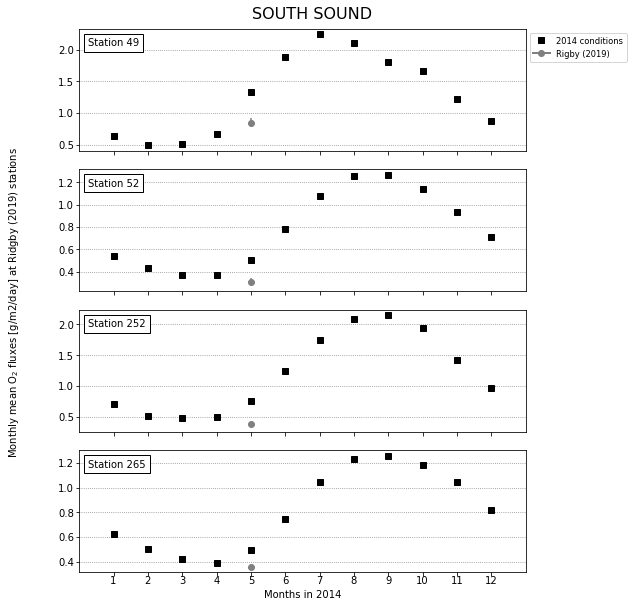

JNH4
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_JNH4_Ridgby2019_SSound_A_monthlyMean.png


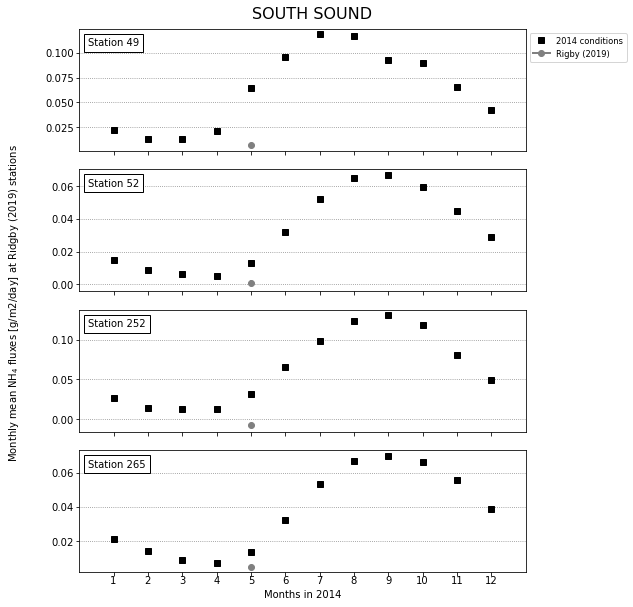

JNO3
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_JNO3_Ridgby2019_SSound_A_monthlyMean.png


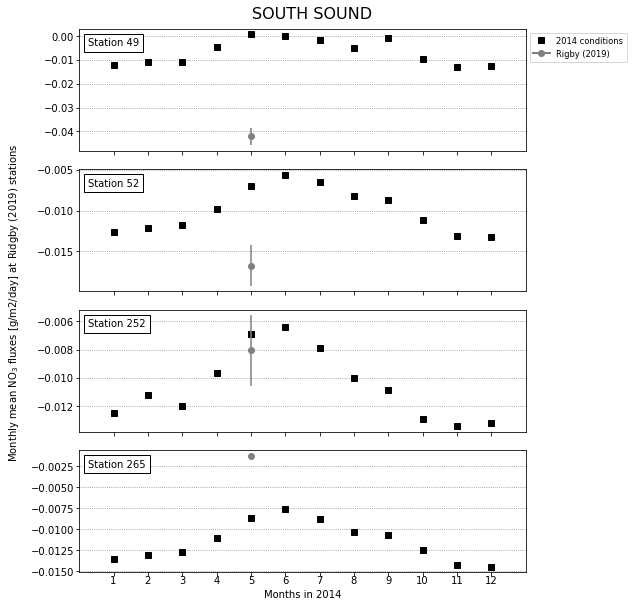

In [26]:
for var in ['SODTM1S', 'JNH4', 'JNO3']:
    print(var)
    monthly_mean = ts_df[var].groupby(pandas.PeriodIndex(pandas.to_datetime(ts[var]['date']), freq="M"))[[*ts_df[var]]].mean()

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10),
                       gridspec_kw={
                       'width_ratios': [.8],
                       'height_ratios': [1,1,1,1],
                   'wspace': 0.25,
                   'hspace': 0.15})
    for ya,station in enumerate(SSound_stations_f['Station'][0:4]):
        # create a list of values
        mean_vals = [value for value in monthly_mean[f"Station {station}"][:][:]]

        # plot results
        ax[ya].plot(
            mean_vals,
            "s",
            color='black',
            label='2014 conditions'
        )
        # # data only for May
        ax[ya].plot(
            4,
            rigby.loc[rigby["Station"]==station][rigby_dict[var]].item(),
            color='grey',
            marker="o",
            lw=2,
            label=f'Rigby (2019)')
        ax[ya].errorbar(
            4,
            rigby.loc[rigby["Station"]==station][rigby_dict[var]].item(),
            color='grey',
            yerr=rigby.loc[rigby["Station"]==station][f"{rigby_dict[var]}_SE"].item(),
        )
        
        

        #     use_index=True,
        #     kind="line",
        #     color='grey',
        #     style='--',
        #     lw=2,
        #     label=f'Scenario'
        # )
        ax[ya].grid(axis='y', color='grey',ls='dotted')
        anchored_text = AnchoredText(
            f'Station {station}',
            loc='upper left',
            frameon=True,
            prop=dict(fontweight="normal",color="black")
        )
        ax[ya].add_artist(anchored_text)
        # set the ylim to the maximum between scenario and baseline
        # y_max = max(np.max(tsdf[station][region]), np.max(ts_base_df[region]))
        # ax[ya].set_ylim(-2e-2*y_max, y_max)
        ax[ya].set_xlim(-1, 12)
        ax[ya].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
        ax[ya].set_xticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
        if (ya!=3):
            ax[ya].set_xticklabels('')
    fig.text(0.0, 0.5,
             f'Monthly mean {title_dict[var]} fluxes [g/m2/day] at Ridgby (2019) stations',
             va='center', rotation='vertical'
            )
    fig.text(0.425, 0.9,
             region.upper(),
             va='center',
             fontsize=16
        )
    ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax[3].set_xlabel('Months in 2014')

    output_file = output_directory/f'base_{var}_Ridgby2019_SSound_A_monthlyMean.png'
    print(f'saving {output_file}')
    plt.savefig(output_file, bbox_inches='tight', format='png')
    plt.show() #clear figure and memory

SODTM1S
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_SODTM1S_Ridgby2019_SSound_A_monthlyMean_nodata.png


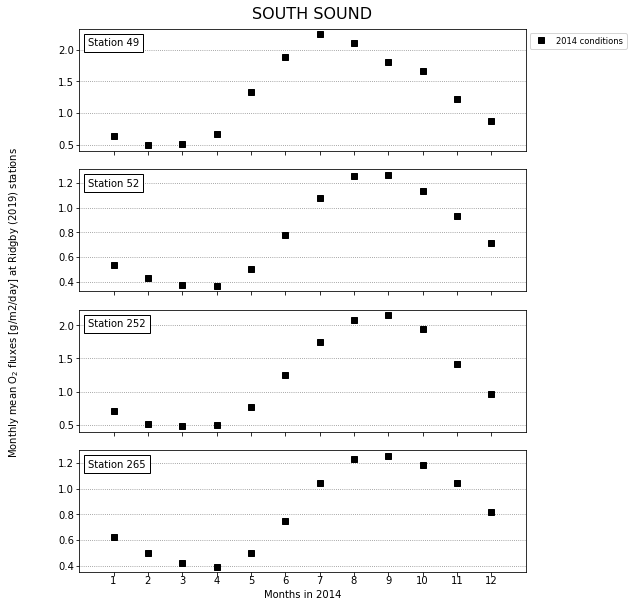

JNH4
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_JNH4_Ridgby2019_SSound_A_monthlyMean_nodata.png


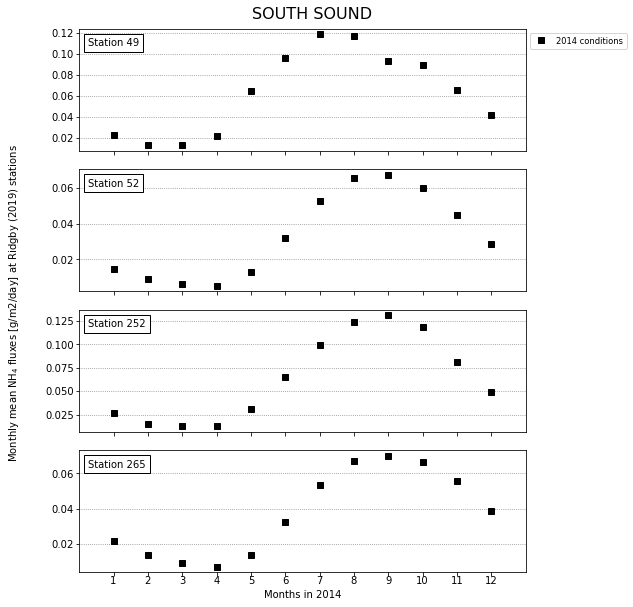

JNO3
saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_JNO3_Ridgby2019_SSound_A_monthlyMean_nodata.png


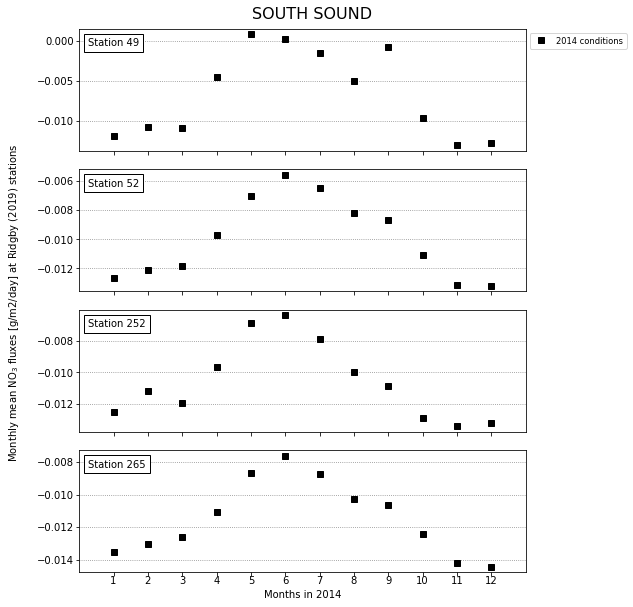

In [25]:
region="South Sound"
title_dict={
    "JNO3": "NO$_3$",
    "JNH4": "NH$_4$",
    "SODTM1S": "O$_2$"
}
rigby_dict={
    "JNO3": "NO3",
    "JNH4": "NH4",
    "SODTM1S": "SOD"
}
for var in ['SODTM1S', 'JNH4', 'JNO3']:
    print(var)
    monthly_mean = ts_df[var].groupby(pandas.PeriodIndex(pandas.to_datetime(ts[var]['date']), freq="M"))[[*ts_df[var]]].mean()

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10),
                       gridspec_kw={
                       'width_ratios': [.8],
                       'height_ratios': [1,1,1,1],
                   'wspace': 0.25,
                   'hspace': 0.15})
    for ya,station in enumerate(SSound_stations_f['Station'][0:4]):
        # create a list of values
        mean_vals = [value for value in monthly_mean[f"Station {station}"][:][:]]

        # plot results
        ax[ya].plot(
            mean_vals,
            "s",
            color='black',
            label='2014 conditions'
        )
        
        ax[ya].grid(axis='y', color='grey',ls='dotted')
        anchored_text = AnchoredText(
            f'Station {station}',
            loc='upper left',
            frameon=True,
            prop=dict(fontweight="normal",color="black")
        )
        ax[ya].add_artist(anchored_text)
        # set the ylim to the maximum between scenario and baseline
        # y_max = max(np.max(tsdf[station][region]), np.max(ts_base_df[region]))
        # ax[ya].set_ylim(-2e-2*y_max, y_max)
        ax[ya].set_xlim(-1, 12)
        ax[ya].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
        ax[ya].set_xticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
        if (ya!=3):
            ax[ya].set_xticklabels('')
    fig.text(0.0, 0.5,
             f'Monthly mean {title_dict[var]} fluxes [g/m2/day] at Ridgby (2019) stations',
             va='center', rotation='vertical'
            )
    fig.text(0.425, 0.9,
             region.upper(),
             va='center',
             fontsize=16
        )
    ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax[3].set_xlabel('Months in 2014')

    output_file = output_directory/f'base_{var}_Ridgby2019_SSound_A_monthlyMean_nodata.png'
    print(f'saving {output_file}')
    plt.savefig(output_file, bbox_inches='tight', format='png')
    plt.show() #clear figure and memory

saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_SODTM1S_Ridgby2019_SSound_B_monthlyMean.png


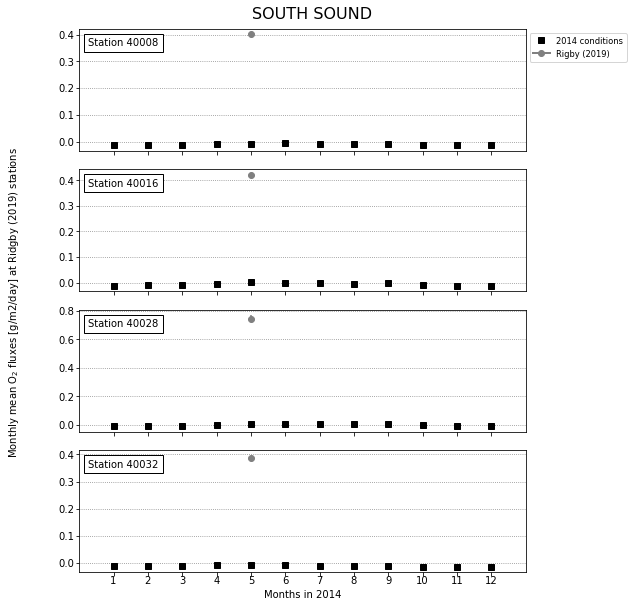

saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_JNH4_Ridgby2019_SSound_B_monthlyMean.png


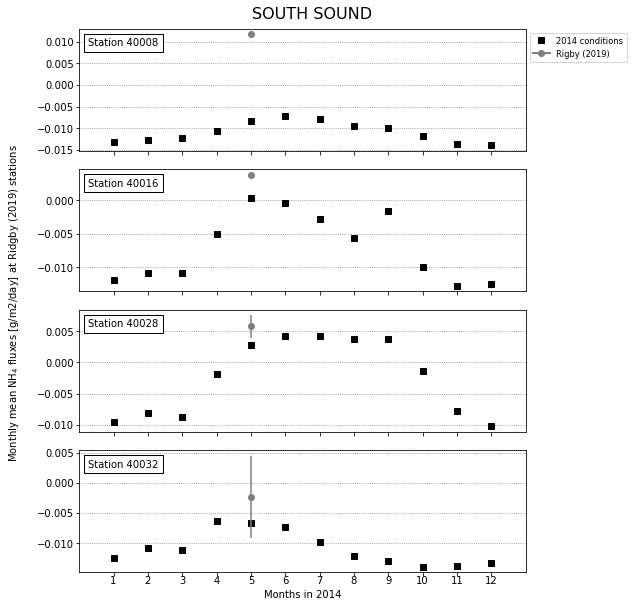

saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_JNO3_Ridgby2019_SSound_B_monthlyMean.png


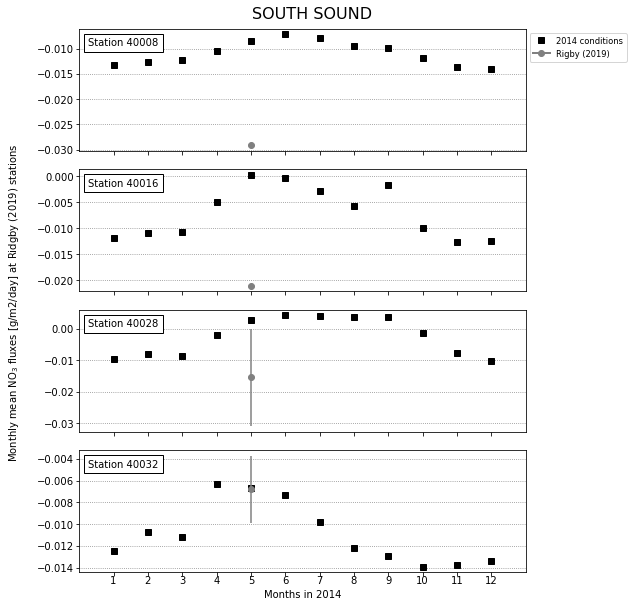

In [27]:
region="South Sound"
for var in ['SODTM1S', 'JNH4', 'JNO3']:

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10),
                       gridspec_kw={
                       'width_ratios': [.8],
                       'height_ratios': [1,1,1,1],
                   'wspace': 0.25,
                   'hspace': 0.15})
    for ya,station in enumerate(SSound_stations_f['Station'][4:9]):
        # create a list of values
        mean_vals = [value for value in monthly_mean[f"Station {station}"][:][:]]

        # plot results
        ax[ya].plot(
            mean_vals,
            "s",
            color='black',
            label='2014 conditions'
        )
        # data only for May
        ax[ya].plot(
            4,
            rigby.loc[rigby["Station"]==station][rigby_dict[var]].item(),
            color='grey',
            marker="o",
            lw=2,
            label=f'Rigby (2019)')
        ax[ya].errorbar(
            4,
            rigby.loc[rigby["Station"]==station][rigby_dict[var]].item(),
            color='grey',
            yerr=rigby.loc[rigby["Station"]==station][f"{rigby_dict[var]}_SE"].item(),
        )
        
        ax[ya].grid(axis='y', color='grey',ls='dotted')
        anchored_text = AnchoredText(
            f'Station {station}',
            loc='upper left',
            frameon=True,
            prop=dict(fontweight="normal",color="black")
        )
        ax[ya].add_artist(anchored_text)
        # set the ylim to the maximum between scenario and baseline
        # y_max = max(np.max(tsdf[station][region]), np.max(ts_base_df[region]))
        # ax[ya].set_ylim(-2e-2*y_max, y_max)
        ax[ya].set_xlim(-1, 12)
        ax[ya].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
        ax[ya].set_xticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
        if (ya!=3):
            ax[ya].set_xticklabels('')
    fig.text(0.0, 0.5,
             f'Monthly mean {title_dict[var]} fluxes [g/m2/day] at Ridgby (2019) stations',
             va='center', rotation='vertical'
            )
    fig.text(0.425, 0.9,
             region.upper(),
             va='center',
             fontsize=16
        )
    ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax[3].set_xlabel('Months in 2014')

    output_file = output_directory/f'base_{var}_Ridgby2019_SSound_B_monthlyMean.png'
    print(f'saving {output_file}')
    plt.savefig(output_file, bbox_inches='tight', format='png')
    plt.show() #clear figure and memory

saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_SODTM1S_Ridgby2019_SSound_B_monthlyMean_nodata.png


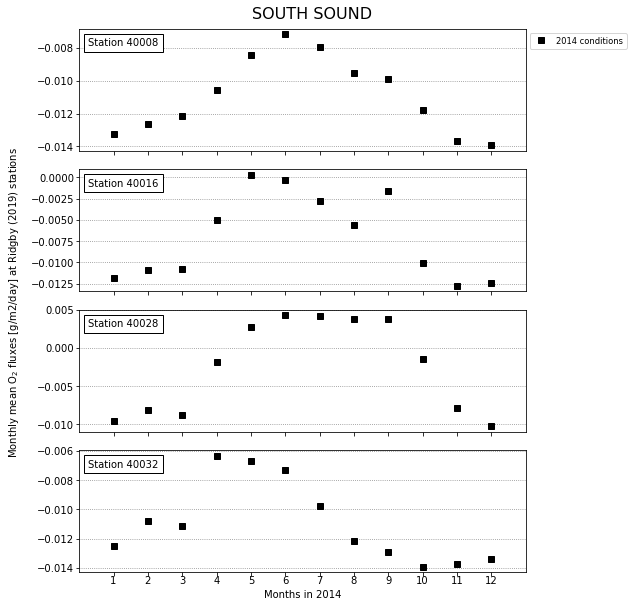

saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_JNH4_Ridgby2019_SSound_B_monthlyMean_nodata.png


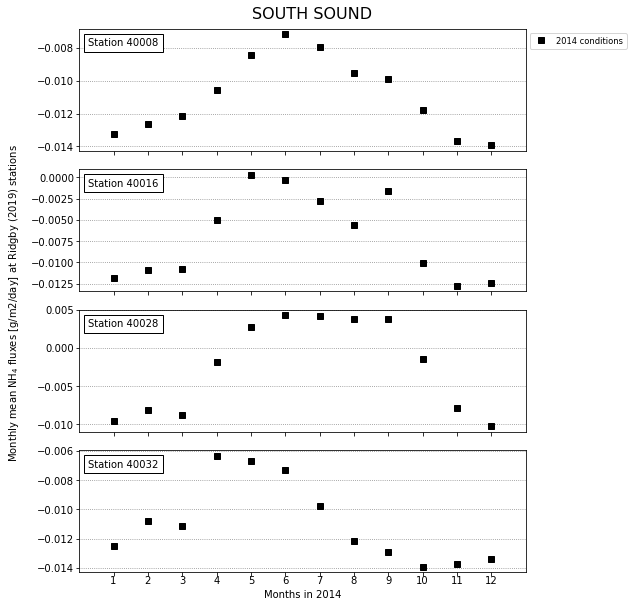

saving /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/sediments/base_JNO3_Ridgby2019_SSound_B_monthlyMean_nodata.png


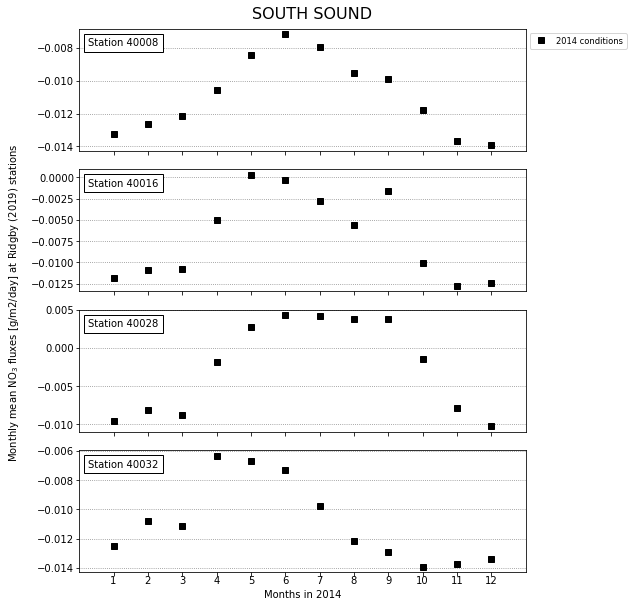

In [28]:
region="South Sound"
for var in ['SODTM1S', 'JNH4', 'JNO3']:

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10),
                       gridspec_kw={
                       'width_ratios': [.8],
                       'height_ratios': [1,1,1,1],
                   'wspace': 0.25,
                   'hspace': 0.15})
    for ya,station in enumerate(SSound_stations_f['Station'][4:9]):
        # create a list of values
        mean_vals = [value for value in monthly_mean[f"Station {station}"][:][:]]

        # plot results
        ax[ya].plot(
            mean_vals,
            "s",
            color='black',
            label='2014 conditions'
        )
        # data only for May
#         ax[ya].plot(
#             4,
#             rigby.loc[rigby["Station"]==station][rigby_dict[var]].item(),
#             color='grey',
#             marker="o",
#             lw=2,
#             label=f'Rigby (2019)')
#         ax[ya].errorbar(
#             4,
#             rigby.loc[rigby["Station"]==station][rigby_dict[var]].item(),
#             color='grey',
#             yerr=rigby.loc[rigby["Station"]==station][f"{rigby_dict[var]}_SE"].item(),
#         )
        
        ax[ya].grid(axis='y', color='grey',ls='dotted')
        anchored_text = AnchoredText(
            f'Station {station}',
            loc='upper left',
            frameon=True,
            prop=dict(fontweight="normal",color="black")
        )
        ax[ya].add_artist(anchored_text)
        # set the ylim to the maximum between scenario and baseline
        # y_max = max(np.max(tsdf[station][region]), np.max(ts_base_df[region]))
        # ax[ya].set_ylim(-2e-2*y_max, y_max)
        ax[ya].set_xlim(-1, 12)
        ax[ya].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
        ax[ya].set_xticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
        if (ya!=3):
            ax[ya].set_xticklabels('')
    fig.text(0.0, 0.5,
             f'Monthly mean {title_dict[var]} fluxes [g/m2/day] at Ridgby (2019) stations',
             va='center', rotation='vertical'
            )
    fig.text(0.425, 0.9,
             region.upper(),
             va='center',
             fontsize=16
        )
    ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax[3].set_xlabel('Months in 2014')

    output_file = output_directory/f'base_{var}_Ridgby2019_SSound_B_monthlyMean_nodata.png'
    print(f'saving {output_file}')
    plt.savefig(output_file, bbox_inches='tight', format='png')
    plt.show() #clear figure and memory

# Load full-domain shapefile

In [ ]:
# get shapefile path    
shp_dir = pathlib.Path(
    "/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-grid/shapefiles/SSMGrid2_tce_ecy_node_info_v2_10102022"
)
# load shapefile into geopandas dataframe
gdf = gpd.read_file(
    shp_dir/"SSMGrid2_tce_ecy_node_info_v2_10102022.shp"
)
gdf=gdf.rename(columns={'region_inf':'Regions'})
[*gdf]

In [ ]:
gdf.shape

# Add sediment fluxes to geodataframe

In [ ]:
day=0
for var in ['SODTM1S', 'JNH4', 'JNO3']:
    gdf[var]=daily_stat[var][day,:]

# Plot sediment fluxes

In [ ]:
mpl.rc('font', size=10)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('legend', fontsize=10)
mpl.rc('axes', titlesize=14)
mpl.rc('axes', labelsize=10)
mpl.rc('figure', titlesize=10)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

fig, axs = plt.subplots(1, figsize = (8,8))
gdf.plot('SODTM1S',
        ax=axs,
        legend=True,
        cmap='OrRd',
        label='Sediment Oxygen Demand [g/m2/day]', alpha = 0.8)

# remove x-, y-labels
#axs.set_xticklabels('')
#axs.set_yticklabels('')
# set legend to lower left corner (instead of default upper-right, which overlaps SOGNB)
legend = axs.get_legend()
# legend._loc = 3 # lower-left
# legend.set_title('Sediment Oxygen Demand [g/m2/day]')
# # get all the legend labels
# legend_labels = axs.get_legend().get_texts()
# Change legend label format from 0.00, 2.00 to 0-2
# get and format all bounds
    

# Add land topography
cx.add_basemap(axs, 
    crs=gdf.crs,
    source=cx.providers.Stamen.TerrainBackground, 
    alpha=1
)

# cx.add_basemap(
#     axs,
#     crs=gdf.crs,
#     source=cx.providers.Stamen.TerrainLabels, 
#     zoom=10)
axs.set_title(f'Mean Daily Sediment Oxygen Demand\nDay {day} of 2014')

# Make time series

In [ ]:
sta_name=["Carr inlet"]
sta_node = [14392]
df_index=[]
idx = 0
df_index.append(gdf.loc[gdf.node_id==sta_node[idx]].index.values.item())

In [ ]:
var='SODTM1S'
daily_stat[var].shape

In [ ]:
plt.plot(ts[var][sta_name[idx_sta]])
plt.xlabel('days in 2014')
plt.ylabel('Sediment Oxygen Demand [g/m2/day]')
plt.title(sta_name[idx_sta])

In [ ]:
idx=0
fig, axs = plt.subplots(1,1, figsize = (32,8),
      gridspec_kw={
          'width_ratios': [1],
          'wspace':0.09
      })
#~~~ Location map ~~~
gdf.plot('depth', ax=axs, legend=True)
# Plot polygon of resulting location
# sub-sample geodataframe with just the selected nodes
gdf_nearest=gdf.loc[gdf.node_id==sta_node[idx]]
gdf_nearest.plot(ax=axs,color='red',legend=True,
                 label='Time series location')
axs.set_ylim(5.9e6,6.1e6)
axs.set_xlim(-1.375e7,-1.355e7)